http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/

In [2]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [73]:
df = pd.read_csv("bank-dataset.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Análisis exploratorio de los datos

In [111]:
df.shape

(45211, 17)

In [79]:
binary_col_list = ['y', 'loan', 'housing', 'default']
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
no,39922,37967,20081,44396
yes,5289,7244,25130,815


In [80]:
df[binary_col_list] = df[binary_col_list].apply(lambda x: x.map(dict(yes=1, no=0)))
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
0,39922,37967,20081,44396
1,5289,7244,25130,815


In [110]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [87]:
df.dtypes

age           int64
job          object
marital      object
education    object
default       int64
balance       int64
housing       int64
loan          int64
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [86]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


Se han de usar técnicas de balanceo de clases, dado que solo hay un 11% de la clase positiva.

In [90]:
null_data = df.isnull().mean()
null_data.sort_values(ascending=False)

y            0.0
loan         0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
contact      0.0
poutcome     0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
age          0.0
dtype: float64

In [105]:
corr = df.corr()
corr

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029979,-0.018329,-0.022419
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236


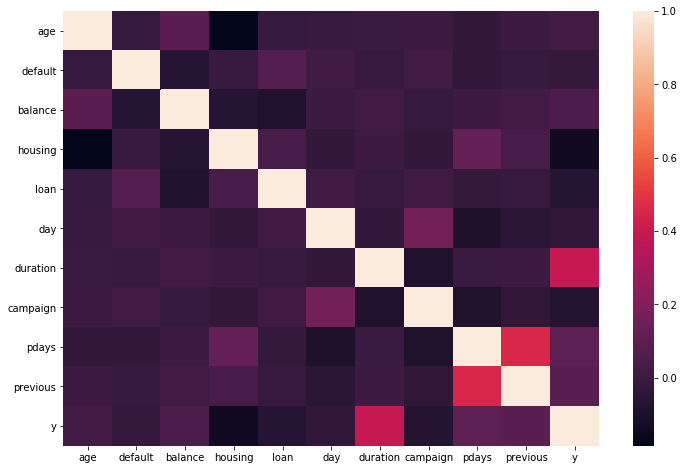

In [106]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Análisis visual de los datos

# Selección del conjunto de datos final

In [113]:
df_dummies = pd.get_dummies(df)

In [114]:
df_dummies.shape

(45211, 49)

# Separación de datos de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_X = df.loc[:, df.columns != 'y'].copy()
df_y = df.y.copy()

TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = TEST_SIZE, random_state = 42)

In [ ]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))